## Import Functions

In [3]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.training_utils import multi_gpu_model
import numpy as np
import pandas as pd
import math
import random
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from mpl_finance import candlestick2_ohlc
import matplotlib.patches as mpatches
import datetime
from collections import deque

In [4]:
## Using The GPU

In [11]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
def make_parallel(model, gpu_count):
    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat([ shape[:1] // parts, shape[1:] ],axis=0)
        stride = tf.concat([ shape[:1] // parts, shape[1:]*0 ],axis=0)
        start = stride * idx
        return tf.slice(data, start, size)
    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    #Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                #Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx':i,'parts':gpu_count})(x)
                    inputs.append(slice_n)                

                outputs = model(inputs)

                if not isinstance(outputs, list):
                    outputs = [outputs]

                #Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])
     # merge outputs on CPU
    with tf.device('/cpu:0'):
        merged = []
        for outputs in outputs_all:
            merged.append(merge(outputs, mode='concat', concat_axis=0))

        return Model(input=model.inputs, output=merged)

## Defining The Agent

In [12]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._model()
#         self.model = load_model(model_name) if is_eval else self._model()
        #self.model = load_model("/home/jediyoda/Maharshi/Project/Model" + model_name) if is_eval else self._model()
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        pmodel = multi_gpu_model(model,2)
        pmodel.compile(loss="mse", optimizer=Adam(lr=0.001))
        return pmodel
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])
    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 
    def load_checkpoint(self, path):
        self.model.load_weights(path)

In [74]:
## Plotting Function

In [2]:
def plots(csv,sell_actions):
    df=pd.read_csv(csv)
    date=df['Date']
    open=df['Open']
    high=df['High']
    low=df['Low']
    close=df['Close']
    fig=plt.figure(figsize=(7,5))
    graph=fig.add_subplot(1,1,1)
    graph.plot(date,close,color='red')
    candlestick2_ohlc(graph,open/2,high,low,close/2,colorup="blue",colordown="red",width=2,alpha=0.5)

## Math-Functions
#### Intuition: This Function Defines How The Input Will Be Processed and The Output Will Be Shown

In [6]:
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))
def getStockDataVec(CSV):
    vec = []
    lines = open(CSV, "r").read().splitlines()
    for line in lines[1:]:
        vec.append(float(line.split(",")[8]))# Selecting The Close Price And Multiplying it By 1000
    return vec
def sigmoid(x):
    return 1 / (1 + math.exp(-x)*1000)
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

## Training The Model

In [13]:
stock_name="/home/jediyoda/Maharshi/Project/Final_Dataset/Final_Data_MCB_Train.csv"
window_size=10
episode_count = 10
agent = Agent(window_size)
data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 32
path = '/home/jediyoda/Maharshi/Project/Model/No_Of_Episodes_420.h5'
agent.load_checkpoint(path)
for e in range(episode_count + 1):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []
    for t in range(l):
        action = agent.act(state)
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0
        if action == 1: # buy
            agent.inventory.append(data[t])
            print("Buy: " + formatPrice(data[t]))
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)
        if e % 10 == 0:
            agent.model.save_weights("/home/jediyoda/Maharshi/Project/Model/No_Of_Episodes_" + str(e)+".h5")

Episode 0/10
Buy: $223.80
Buy: $223.50
Buy: $223.61
Buy: $229.00
Sell: $238.50 | Profit: $14.70
Buy: $239.55
Sell: $238.05 | Profit: $14.55
Buy: $231.20
Sell: $229.76 | Profit: $6.15
Buy: $232.50
Sell: $231.30 | Profit: $2.30
Buy: $225.00
Buy: $221.50
Sell: $224.05 | Profit: -$15.50
Sell: $227.80 | Profit: -$3.40
Sell: $222.04 | Profit: -$10.46
Buy: $213.55
Buy: $213.25
Sell: $211.33 | Profit: -$13.67
Sell: $206.00 | Profit: -$15.50
Buy: $205.03
Buy: $195.89
Sell: $195.55 | Profit: -$18.00
Sell: $203.50 | Profit: -$9.75
Sell: $210.60 | Profit: $5.57
Buy: $216.50
Sell: $219.11 | Profit: $23.22
Sell: $223.61 | Profit: $7.11
Buy: $214.01
Buy: $193.20
Sell: $194.60 | Profit: -$19.41
Buy: $195.00
Sell: $195.50 | Profit: $2.30
Buy: $197.80
Buy: $202.00
Sell: $205.70 | Profit: $10.70
Sell: $206.55 | Profit: $8.75
Sell: $204.50 | Profit: $2.50
Buy: $203.00
Buy: $203.15
Sell: $197.11 | Profit: -$5.89
Sell: $197.31 | Profit: -$5.84
Buy: $198.25
Buy: $202.30
Sell: $202.65 | Profit: $4.40
Buy: $20

## Testing The Model

In [54]:
stock_name="/home/jediyoda/Maharshi/Project/Final_Dataset/Final_Data_MCB_Test.csv"
model_name = "/home/jediyoda/Maharshi/Project/Model/No_Of_Episodes_400.hdf5"
agent.model.load_weights(model_name)
window_size = agent.model.layers[0].input.shape.as_list()[1]
agent = Agent(window_size, True, model_name)
data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 32
state = getState(data, 0, window_size + 1)
total_profit = 0
buy_actions=[]
sell_actions=[]
agent.inventory = []
for t in range(l):
    action = agent.act(state)
    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0
    if action == 1: # buy
        agent.inventory.append(data[t])
        print("Buy: " + formatPrice(data[t]))
        buy_actions.append(data[t])
    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        reward = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        sell_actions.append(data[t])
    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state
    if done:
        print("--------------------------------")
        print(stock_name + " Total Profit: " + formatPrice(total_profit))
        print("--------------------------------")

Buy: $233.90
Buy: $233.00
Buy: $232.51
Buy: $234.50
Sell: $236.80 | Profit: $2.90
Sell: $232.62 | Profit: -$0.38
Buy: $232.35
Buy: $232.00
Sell: $234.00 | Profit: $1.49
Buy: $235.51
Sell: $235.00 | Profit: $0.50
Buy: $237.90
Buy: $240.00
Sell: $239.80 | Profit: $7.45
Buy: $237.00
Buy: $236.60
Buy: $238.10
Sell: $238.70 | Profit: $6.70
Buy: $244.00
Sell: $254.00 | Profit: $18.49
Sell: $249.50 | Profit: $11.60
Sell: $244.51 | Profit: $4.51
Buy: $239.00
Sell: $242.00 | Profit: $5.00
Sell: $242.10 | Profit: $5.50
Sell: $242.48 | Profit: $4.38
Buy: $242.70
Sell: $242.00 | Profit: -$2.00
Sell: $241.50 | Profit: $2.50
Sell: $240.00 | Profit: -$2.70
Buy: $240.00
Sell: $238.50 | Profit: -$1.50
Buy: $237.00
Sell: $229.75 | Profit: -$7.25
Buy: $225.10
Sell: $225.50 | Profit: $0.40
Buy: $224.00
Sell: $221.00 | Profit: -$3.00
Buy: $223.30
Sell: $225.00 | Profit: $1.70
Buy: $226.70
Buy: $228.00
Buy: $228.00
Sell: $229.50 | Profit: $2.80
Buy: $228.00
Buy: $226.00
Buy: $226.52
Buy: $229.00
Buy: $230.0

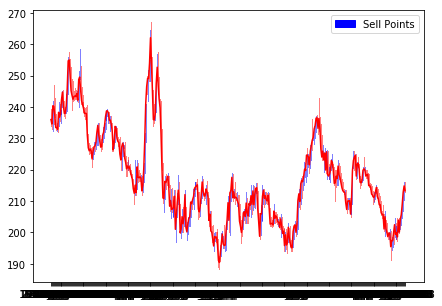

In [4]:
plots(stock_name,sell_actions)